In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import useful_functions as ut
import fitsio
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from glob import glob
fns = glob("/pscratch/sd/a/arosado/lognormal_mocks/cutsky/test1.2/data_cutsky_3.0_2500.0_1024_8000.0_3.0_ph????.fits")

In [5]:
fitsio.FITS(fns[0])[1].get_nrows()

18313047

In [13]:
%%time
nbar_deg = 2500
a = []
for i,fn in enumerate(fns):
    print(f"{i}/{len(fns)}",end='\r')
    d = fitsio.(fn,columns=['Z','mask_checkerboard'])
    m = d['mask_checkerboard']
    a.append(d['Z'][m].size/nbar_deg)


CPU times: user 1min 17s, sys: 1min 42s, total: 2min 59s
Wall time: 3min 4s


In [15]:
%%time
nbar_deg = 2500
b = []
for i,fn in enumerate(fns):
    print(f"{i}/{len(fns)}",end='\r')
    d = fitsio.read(fn,columns=['Z','mask_contiguous'])
    m = d['mask_contiguous']
    b.append(d['Z'][m].size/nbar_deg)


CPU times: user 1min 11s, sys: 1min 16s, total: 2min 27s
Wall time: 2min 30s


In [17]:
np.mean(a),np.mean(b)

(4002.6385840000007, 4002.0717359999994)

In [6]:
version = 'test1'
cutsky_version = 'test1.2'
if os.getenv('PSCRATCH')==None:
    base_dir = os.path.join(os.getenv('CSCRATCH'), 'lognormal_mocks')
else:
    base_dir = os.path.join(os.getenv('PSCRATCH'), 'lognormal_mocks')
cubic_dir = os.path.join(base_dir, 'cubic', version)
cutsky_dir = os.path.join(base_dir, 'cutsky', cutsky_version)
plot_dir = os.path.join(cutsky_dir, 'plots')
if not os.path.isdir(plot_dir):
    os.makedirs(plot_dir)
    print(f"created dir: {plot_dir}")

In [7]:
zmin = 2.75
zmax = 3.25
zeff = None
if zeff is None:
    zeff = (zmax + zmin)/2.
print(f"zmin={zmin}, zmax={zmax}, zeff={zeff}")

bias=3.0
nb_deg=2500
nmesh=1024
boxsize = 8000.
seed_id=10
ph = str(seed_id).zfill(4)

zmin=2.75, zmax=3.25, zeff=3.0


In [8]:
file_id = f"{bias}_{float(nb_deg)}_{nmesh}_{boxsize}_{zeff}_ph{ph}"
data_fn = os.path.join(cutsky_dir, 'data_cutsky_'+file_id+'.fits')

data_cutsky = fitsio.read(data_fn)
mask_contiguous = data_cutsky['mask_contiguous']
mask_checkerboard = data_cutsky['mask_checkerboard']

# Plot skymaps

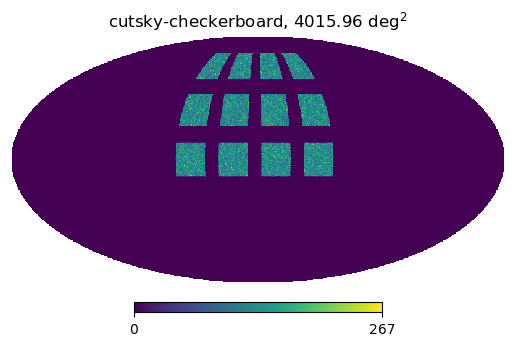

In [9]:
plt.clf() 
fig = plt.gcf() #plt.figure(figsize=(10,5))
title = f"cutsky-checkerboard, {len(data_cutsky[mask_checkerboard])/nb_deg:.2f} "+ r"$\mathrm{deg}^{2}$"
ut.plot_mollview(data_cutsky[mask_checkerboard], 256, rot=-130, title=title, hold=True)
filename = os.path.join(plot_dir,f'cutsky_checkerboard_ph{ph}.png')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

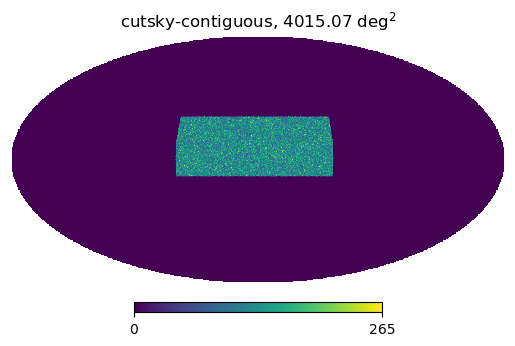

In [8]:
plt.clf() 
fig = plt.gcf() #plt.figure(figsize=(10,5))
title = f'cutsky-contiguous, {len(data_cutsky[mask_contiguous])/nb_deg:.2f} ' +  r"$\mathrm{deg}^{2}$"
ut.plot_mollview(data_cutsky[mask_contiguous], 256, rot=-130, title=title, hold=True)
filename = os.path.join(plot_dir,f'cutsky_contiguous_ph{ph}.png')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

# Test different cuts

In [6]:
ramin, ramax = [175, 290]
decmin, decmax = [-10, 70]
rarange_list = ut.split_range(ramin, ramax, nchunks=4,sep=10)
decrange_list = ut.split_range(decmin, decmax, nchunks=3,sep=10)
print(f"Choosing distance, RA, Dec ranges:")
print(f"RA ranges: {rarange_list}")
print(f"DEC ranges: {decrange_list}")

count = np.zeros(data_cutsky['RA'].size)
for i, rarange in enumerate(rarange_list):
    count += (rarange[0] <= data_cutsky['RA']) & (data_cutsky['RA'] <= rarange[1]) * 1 # multply by 1 gives integer array
for j, decrange in enumerate(decrange_list):
    count += (decrange[0] <= data_cutsky['DEC']) & (data_cutsky['DEC'] <= decrange[1]) * 1    
print(np.unique(count))
mask_checkerboard = count == count.max()
area_checkerboard = mask_checkerboard.sum()/nb_deg
print(mask_checkerboard.sum(),data_cutsky['RA'].size, mask_checkerboard.sum()/data_cutsky['RA'].size)

Choosing distance, RA, Dec ranges:
RA ranges: [[175.0, 196.25], [206.25, 227.5], [237.5, 258.75], [268.75, 290.0]]
DEC ranges: [[-10.0, 10.0], [20.0, 40.0], [50.0, 70.0]]
[0. 1. 2.]
10039891 18379352 0.5462592478777272


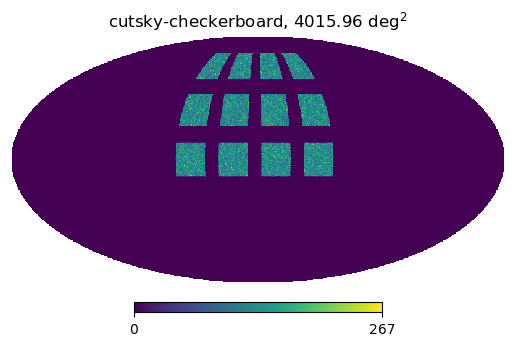

In [7]:
plt.clf() 
fig = plt.gcf() #plt.figure(figsize=(10,5))
title = f"cutsky-checkerboard, {len(data_cutsky[mask_checkerboard])/nb_deg:.2f} "+ r"$\mathrm{deg}^{2}$"
ut.plot_mollview(data_cutsky[mask_checkerboard], 256, rot=-130, title=title, hold=True)
filename = os.path.join(plot_dir,f'cutsky_checkerboard_ph{ph}.png')
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [14]:
%%time 
# Let us cut further (contiguous case)
mask_contiguous = ut.mask_to_match_skyarea(data_cutsky, nb_deg, area_checkerboard, field='DEC', step=0.1)
area_contiguous = mask_contiguous.sum()/nb_deg
print(area_checkerboard, area_contiguous)

number of objects to be removed 8339461.0 (45.37%)
optimal DEC to perform cut: 25.70
4015.9564 4010.9328
CPU times: user 1min 18s, sys: 28.2 ms, total: 1min 18s
Wall time: 1min 18s


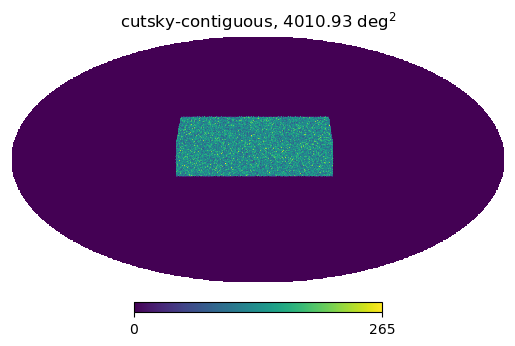

In [15]:
plt.clf() 
fig = plt.gcf() #plt.figure(figsize=(10,5))
title = f'cutsky-contiguous, {len(data_cutsky[mask_contiguous])/nb_deg:.2f} ' +  r"$\mathrm{deg}^{2}$"
ut.plot_mollview(data_cutsky[mask_contiguous], 256, rot=-130, title=title, hold=True)
filename = os.path.join(plot_dir,f'cutsky_contiguous_ph{ph}.png')
#fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
# just need to change bins, weights, and zbins zmin and zmax
bins = 100
z = data_cutsky['Z']
weights = np.full_like(z, 1./2500)
zbins = np.linspace(2.70,3.30,bins+1)
counts, pbins = np.histogram(z,bins=zbins,weights=weights)
bc = (pbins[:-1] + pbins[1:]) / 2
plt.plot(bc,counts)